# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Finding Lane Lines on the Road** 
***
This project focused on lane finding from a dashboard mounted camera. First, an image analysis pipeline is developed using a series of individual images, and then applied a video stream to assess the performance of lane finding with an environment with curved road features.

The program flow is as follows:
* Perform camera calibration
* Perform distortion correction
* Perform top-down perspective transform
* Investigate color/gradient threshold transformations
* Extract lane line features from top-down image
* Calculate lane curvature through polynomial fit
* Overlay lane visualization on video frames and print out metrics

### Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import glob
import pickle

%matplotlib inline

### Read in example image and verify shape

Image type: <class 'numpy.ndarray'>
Image shape: (720, 1280, 3)


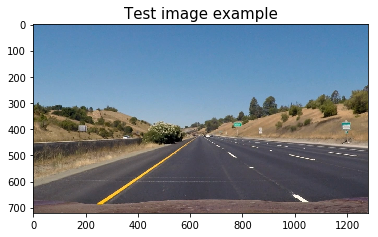

In [2]:
# Read in a test image

test_image = mpimg.imread('test_images/straight_lines1.jpg')

# Check image type, shape

print('Image type:', type(test_image))
print('Image shape:', test_image.shape)
plt.title('Test image example', fontsize=15)
plt.imshow(test_image)

### Define Useful Functions

In [3]:
# Define a function to plot images for comparision as needed to show the result of transformations

def plot_two_images(img1, img2, title_1, title_2, outname = None, save = None):
    
    # Plot images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))

    ax1.imshow(img1)
    ax1.set_title(title_1, fontsize=30)
    
    ax1.set_xlabel('x dimension', fontsize = 20)
    ax1.set_ylabel('y dimension', fontsize = 20)

    ax2.imshow(img2)
    ax2.set_title(title_2, fontsize=30)
    
    ax2.set_xlabel('x dimension', fontsize = 20)
    ax2.set_ylabel('y dimension', fontsize = 20)

    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    if save == True:
        plt.savefig('./output_images/' + outname + '.jpg')
    
    plt.show
    
    return

# Define a function which exports all images from a series

def plot_all_images(imgs, export_folder, fnames):
    
    for i, img in enumerate(imgs):
        export_fname = os.path.join(export_folder, fnames[i])
        ret = cv2.imwrite(export_fname, img)
        
        if ret:
            print('Saved: {}'.format(export_fname))
        else:
            print('Image not Saved!:{}'.format(export_fname))

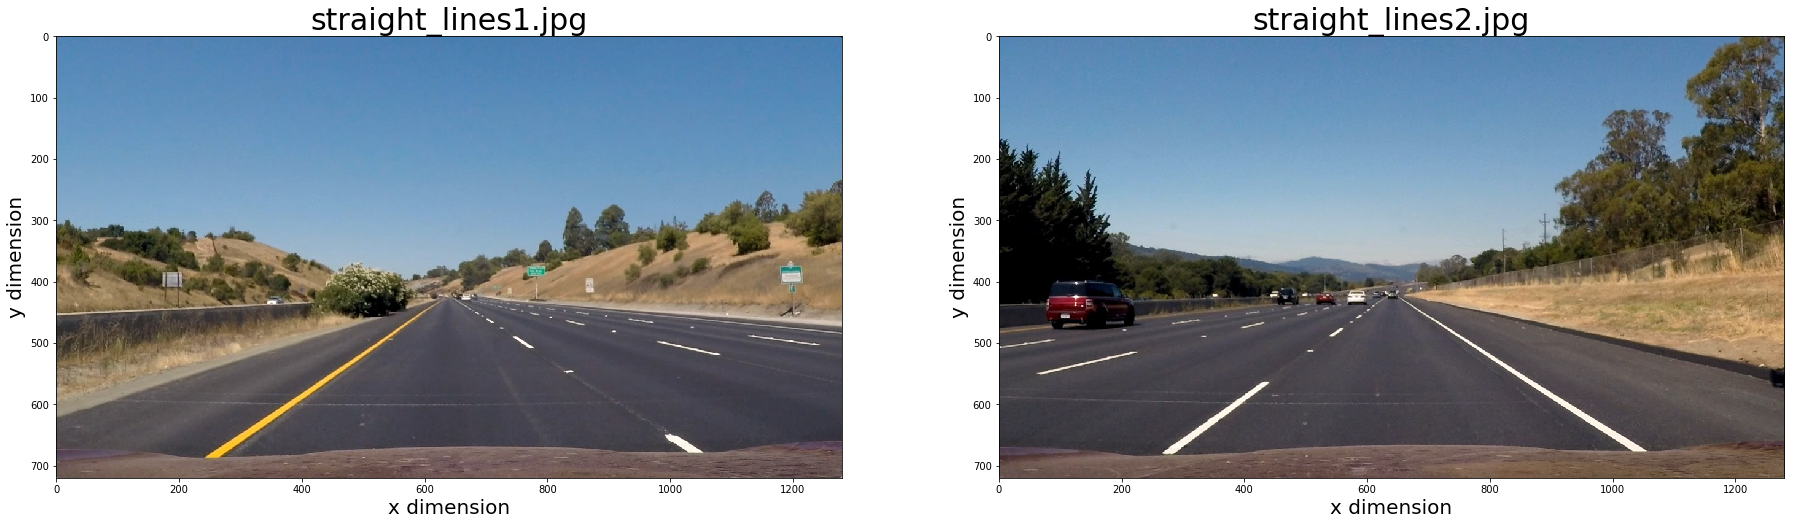

In [4]:
# Test image function

image_test1 = mpimg.imread('test_images/straight_lines1.jpg')
image_test2 = mpimg.imread('test_images/straight_lines2.jpg')

plot_two_images(image_test1, image_test2, title_1 = 'straight_lines1.jpg', title_2 = 'straight_lines2.jpg', outname = 'imageplottest', save = True)

### 1. Camera Calibration
***
ChessBoard calibration images are read in, then cv2 functions are used to identify the corners within the ChessBoard calibration images. The calibration information is then saved as a calibration file which can be used later when applying distortion correction.

In [5]:
# Define a set of object points
objp = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Define arrays to store object (3D space) and image (2D space) points from imported images
objpoints = []
imgpoints = []

# print a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Iterate through the list, searching for chesseboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Use cv2 to find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    if ret == True:
        print('working on ', fname)
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Draw the found corners, save images to the output_images folder
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        write_name = 'corners_found' + str(idx) + '.jpg'
        cv2.imwrite('./output_images/chessboard_images/' + write_name, img)
        
# Load image for reference
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Perform camera calibration for the given object and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Save the calibration file
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("./camera_cal/calibration_pickle.p", "wb"))

working on  ./camera_cal\calibration10.jpg
working on  ./camera_cal\calibration11.jpg
working on  ./camera_cal\calibration12.jpg
working on  ./camera_cal\calibration13.jpg
working on  ./camera_cal\calibration14.jpg
working on  ./camera_cal\calibration15.jpg
working on  ./camera_cal\calibration16.jpg
working on  ./camera_cal\calibration17.jpg
working on  ./camera_cal\calibration18.jpg
working on  ./camera_cal\calibration19.jpg
working on  ./camera_cal\calibration2.jpg
working on  ./camera_cal\calibration20.jpg
working on  ./camera_cal\calibration3.jpg
working on  ./camera_cal\calibration6.jpg
working on  ./camera_cal\calibration7.jpg
working on  ./camera_cal\calibration8.jpg
working on  ./camera_cal\calibration9.jpg


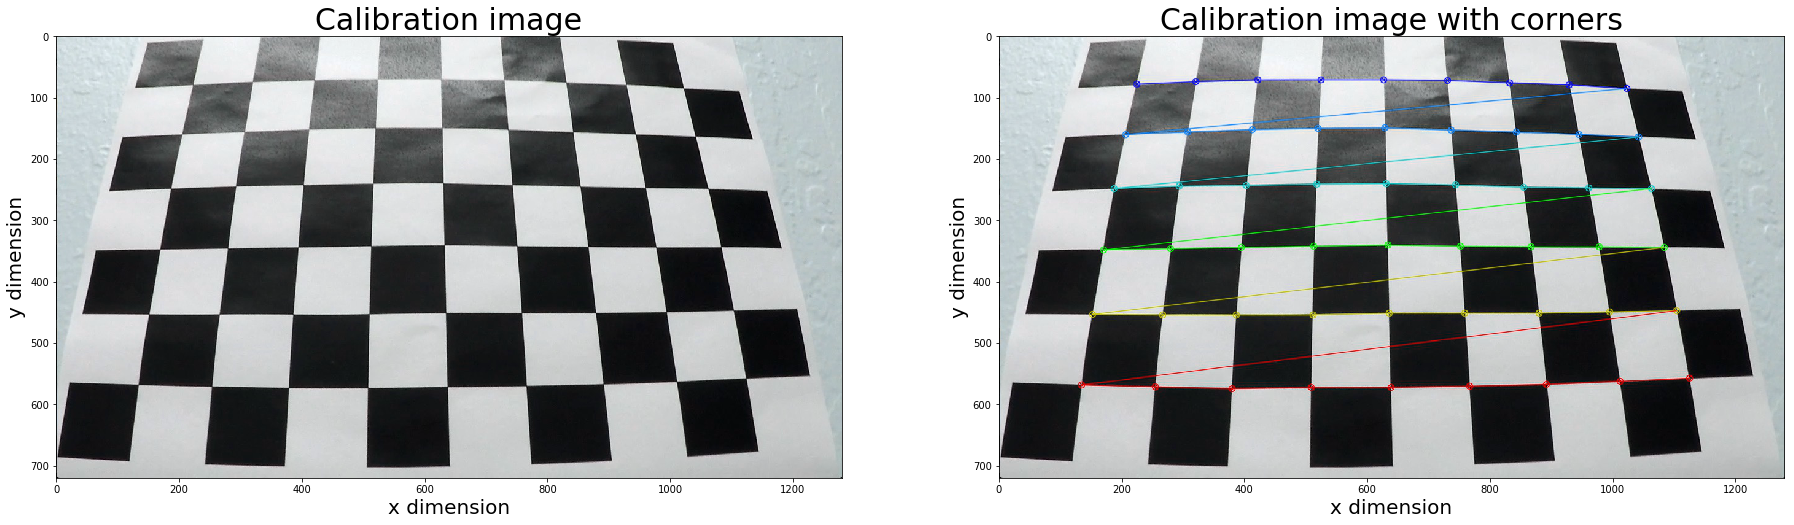

In [6]:
# Plot an example of the calibration image and after finding corners

cal_img_3 = cv2.imread('./camera_cal/calibration3.jpg')
foundlines_img_13 = cv2.imread('./output_images/chessboard_images/corners_found13.jpg')

plot_two_images(cal_img_3, foundlines_img_13,
                title_1 = 'Calibration image', title_2 = 'Calibration image with corners',
                outname = 'Calibration image with corners', save = True)

### Define Undistortion Function
***
The camera calibration file is used to undistort the images.

In [7]:
# Read in the saved camera matrix and distortion coefficients

dist_pickle = pickle.load(open("camera_cal/calibration_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in a test image
img = cv2.imread('./camera_cal/calibration3.jpg')

# Define chessboard size parameters, nx (number of inside corners in x) and ny (number of inside corners in y)

nx = 9
ny = 6

def corners_unwarp(img, nx, ny, mtx, dist):
    
    # Undistort using mtx and dist
    img_size = (img.shape[1], img.shape[0])
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    
    # Darw corners if corners are found
    if ret == True:
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        
        # Define 4 source points src = np.float32([[,],[,],[,],[,]])
        # Detected corners found using the automatic corner detection
        offset = 100
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
            
        # Define 4 destination points dst = np.float32([[,],[,],[,],[,]])
        dst = np.float32([[offset, offset],[img_size[0]-offset, offset],[img_size[0]-offset, img_size[1]-offset],[offset, img_size[1]-offset]])
            
        # Use cv2.getPerspectiveTransform() to get M, the transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
            
        # Use cv2.warpPerspective() to warp your image to a top-down view
        warped = cv2.warpPerspective(undist, M, img_size)
    
    return warped, M

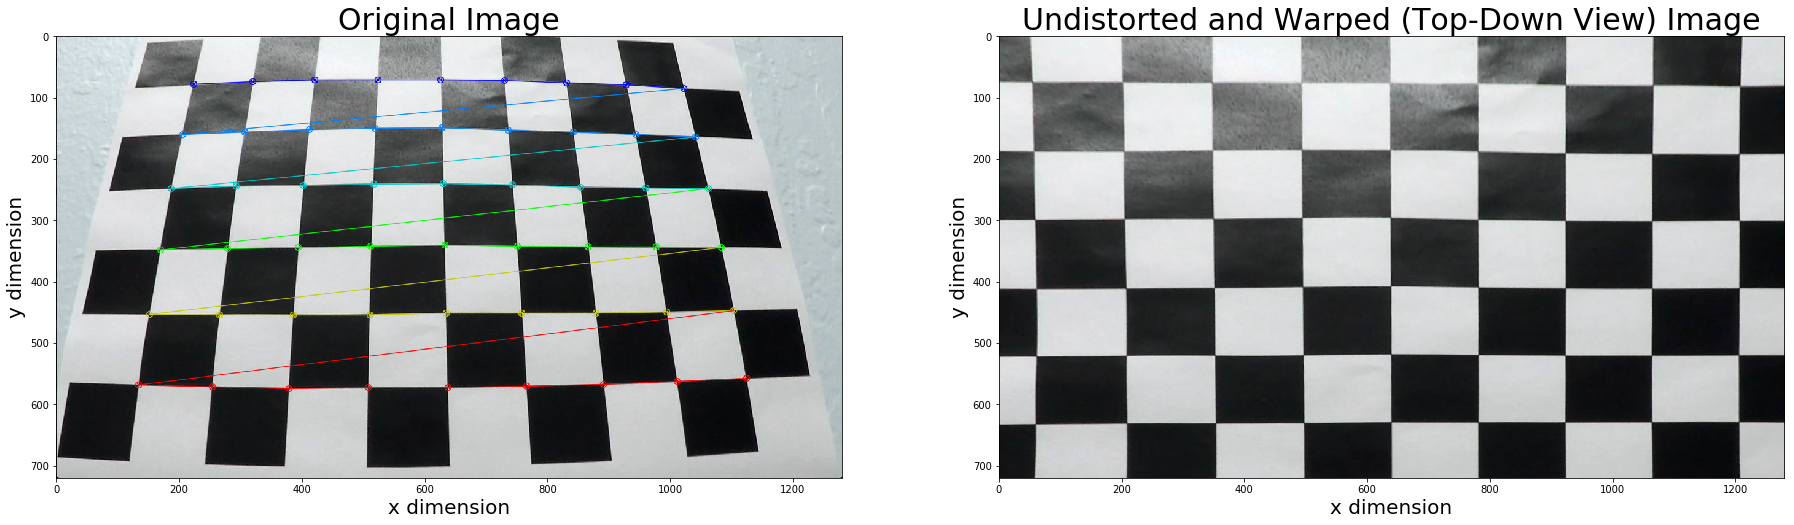

In [8]:
# Test the undistort and top-down transformation on a calibration image

top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)

plot_two_images(img, top_down,
                title_1 = 'Original Image', title_2 = 'Undistorted and Warped (Top-Down View) Image',
                outname = 'undistort_chessboard', save = True)

In [9]:
# Define a stand-alone function to perform the top-down perspective warp

def perspective_transform(image):

    img_size = (image.shape[1], image.shape[0])

    preprocessImage = np.zeros_like(img[:,:,0])

    bot_width = 0.75 # percent of bottom trapizoid height
    mid_width = 0.08 # percent of middle trapizoid height
    height_pct = 0.62 # percent for trapizoid width
    bottom_trim = 0.95 # percent from top to bottom to avoid car hood

    src = np.float32([[img.shape[1] * (0.5 - mid_width / 2), img.shape[0] * height_pct],
                      [img.shape[1] * (0.5 + mid_width / 2), img.shape[0] * height_pct],
                      [img.shape[1] * (0.5 + bot_width / 2), img.shape[0] * bottom_trim],
                      [img.shape[1] * (0.5 - bot_width / 2), img.shape[0] * bottom_trim]])

    offset = img_size[0] * 0.25

    dst = np.float32([[offset, 0], [img_size[0]-offset, 0], [img_size[0]-offset, img_size[1]], [offset, img_size[1]]])
    
    # Define topdown perspective transform

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective(image, M, img_size, flags = cv2.INTER_LINEAR)

    return warped


In [ ]:
# Test the perspective transform on different lane types: straight vs. curved
# Print out example images of straight vs curved lanes

straight_lane_test = mpimg.imread('test_images/straight_lines1.jpg')
curved_lane_test = mpimg.imread('test_images/test2.jpg')

warp_test_straight = perspective_transform(straight_lane_test)
warp_test_curved = perspective_transform(curved_lane_test)

plot_two_images(straight_lane_test, warp_test_straight,
                title_1 = 'Straight Lane', title_2 = 'Straight Lane (Top-Down View)',
                outname = 'straight_lane_warp_test', save = True)

plot_two_images(curved_lane_test, warp_test_curved,
                title_1 = 'Curved Lane', title_2 = 'Curved Lane (Top-Down View)',
                outname = 'curved_lane_warp_test', save = True)

### Sobel Functions
***
Define the Sobel threshold transformation function.

In [11]:
# Define the Absolute Sobel Threshold Function that applies Sobel x or y, and then takes an absolute value and applies a threshold.

def abs_sobel_thresh(img, orient='x', sobel_kernel = 5, thresh = (0, 255)):
    
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take the derivative in x or y given orient = 'x' or 'y'
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
        
    # Take the absolute value of the derivative or gradient
    if orient == 'x':
        abs_sobel = np.absolute(sobelx)
    if orient == 'y':
        abs_sobel = np.absolute(sobely)
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    
    # Create a mask of 1's where the scaled gradient magnitude 
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_output

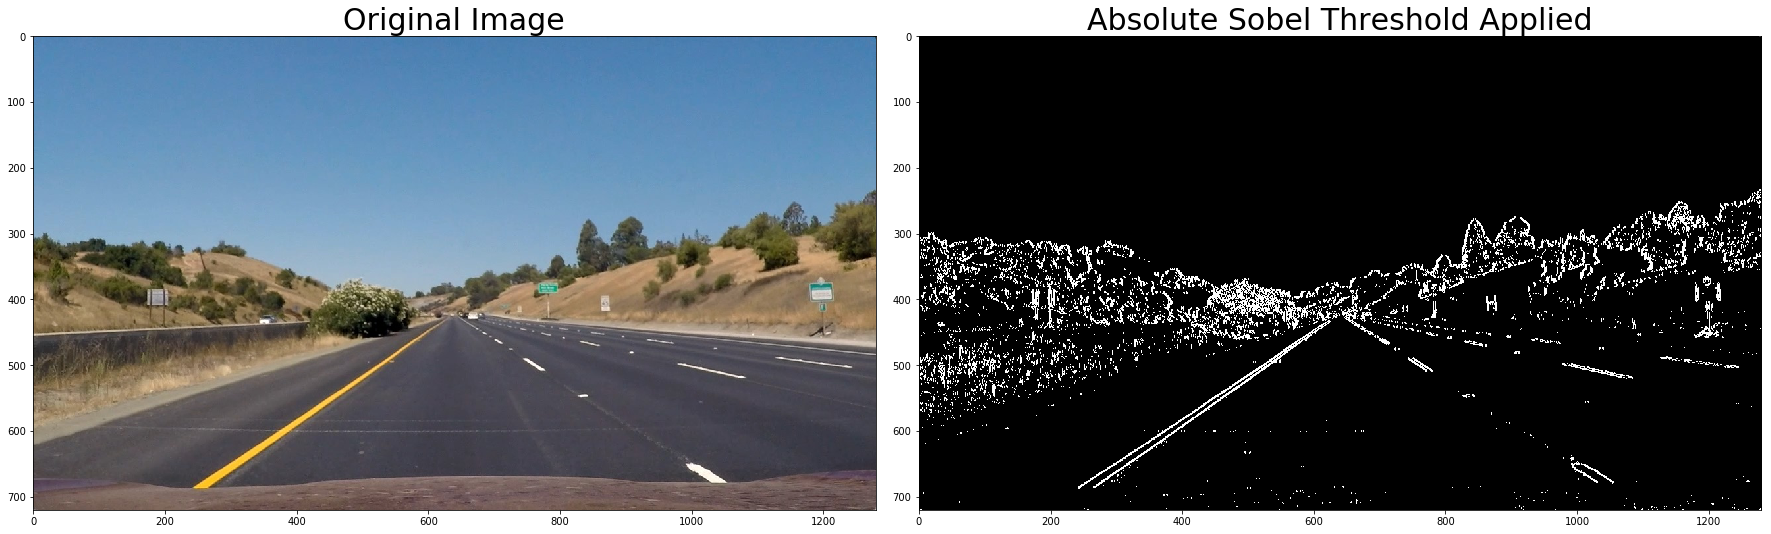

In [12]:
# Test the abs_sobel_thresh function
# Read in a test image and grayscale it
image_test = mpimg.imread('test_images/straight_lines1.jpg')
    
# Run the function to test
grad_binary = abs_sobel_thresh(image_test, orient='x', thresh = (20, 250))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image_test)
ax1.set_title('Original Image', fontsize=30)

ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Absolute Sobel Threshold Applied', fontsize=30)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('./output_images/' + 'abs_soble_thresh_test' + '.jpg')

In [13]:
# Define and test the Magnitude Sobel Threshold Function.

def mag_thresh(image, sobel_kernel = 3, mag_thresh = (0, 255)):
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag / scale_factor).astype(np.uint8)
    binary_output = np.zeros_like(gradmag)
    
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag < mag_thresh[1])] = 1
    
    return binary_output

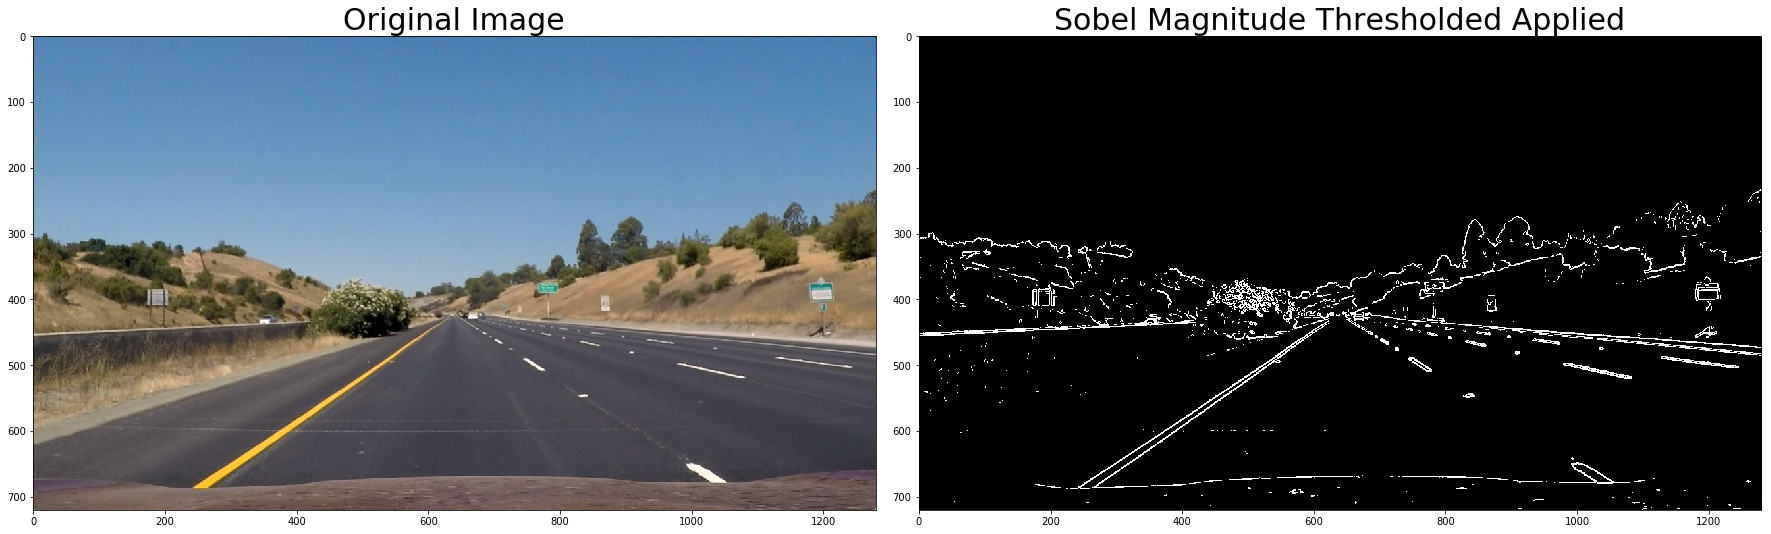

In [14]:
# Test the mag_thresh function on test_image    

mag_thresh_test = mag_thresh(image_test, sobel_kernel = 3, mag_thresh = (50, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image_test)
ax1.set_title('Original Image', fontsize=30)

ax2.imshow(mag_thresh_test, cmap='gray')
ax2.set_title('Sobel Magnitude Thresholded Applied', fontsize=30)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('./output_images/' + 'mag_thresh_test' + '.jpg')

### Color Filtering and Transformations
***
First, the ChessBoard calibration images are read into a function and cv2 functions are used to identify the corners within the ChessBoard calibration images. The calibration information is then saved as a calibration file which can be used later when applying distortion correction.

In [15]:
# Define HLS Color Threshold Function that thresholds the S-channel of HLS and test it.

def hls_select(img, thresh=(0, 255)):
    
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    # Apply a threshold to the S channel
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    
    return binary_output

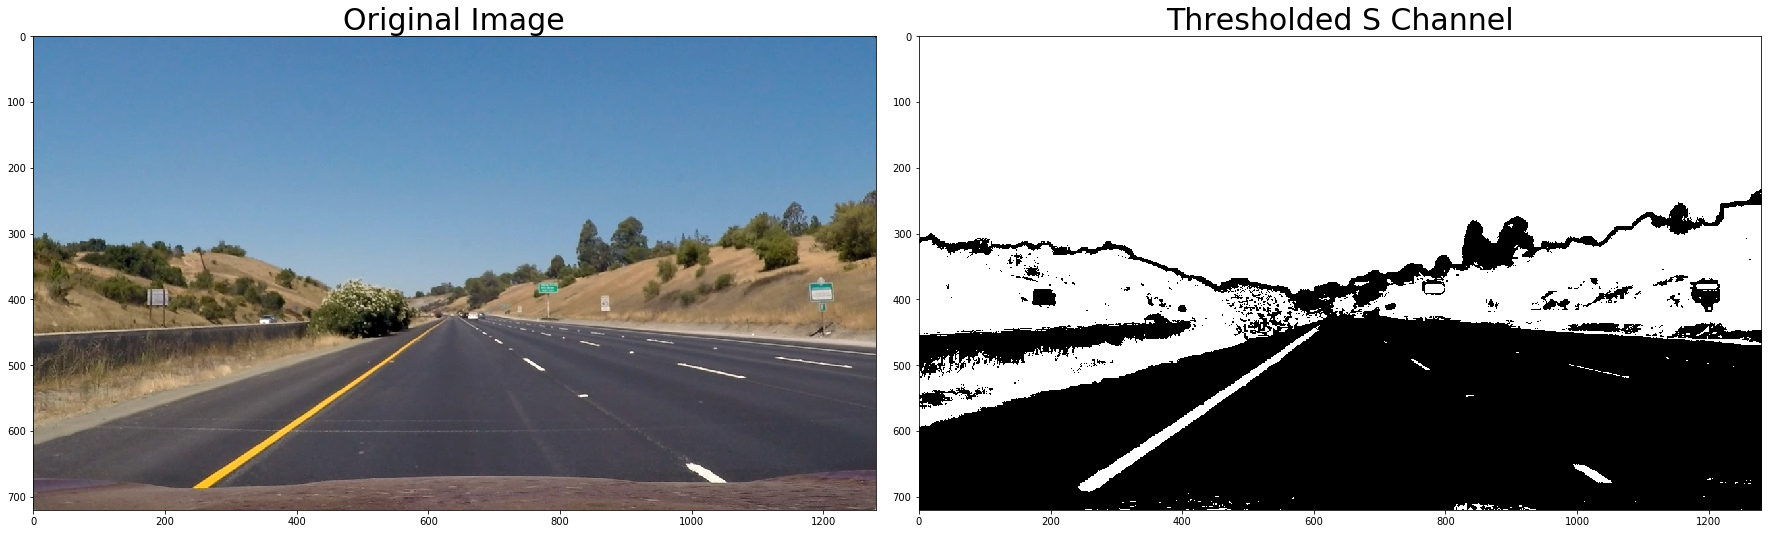

In [16]:
# Test the hls_select function

hls_binary = hls_select(image_test, thresh=(50, 255))

# Read in a test image
#image = mpimg.imread('test_images/straight_lines1.jpg') 

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image_test)
ax1.set_title('Original Image', fontsize=30)

ax2.imshow(hls_binary, cmap='gray')

ax2.set_title('Thresholded S Channel', fontsize=30)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('./output_images/' + 'hls_binary_test' + '.jpg')

In [17]:
# Define a color threshold function with HLS and HSV and test it.

def color_threshold(image, sthresh = (0,255), vthresh=(0,255)):
    
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] = 1
    
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= vthresh[0]) & (v_channel <= vthresh[1])] = 1
    
    output = np.zeros_like(s_channel)
    output[(s_binary == 1) & (v_binary == 1)] = 1
    
    return output

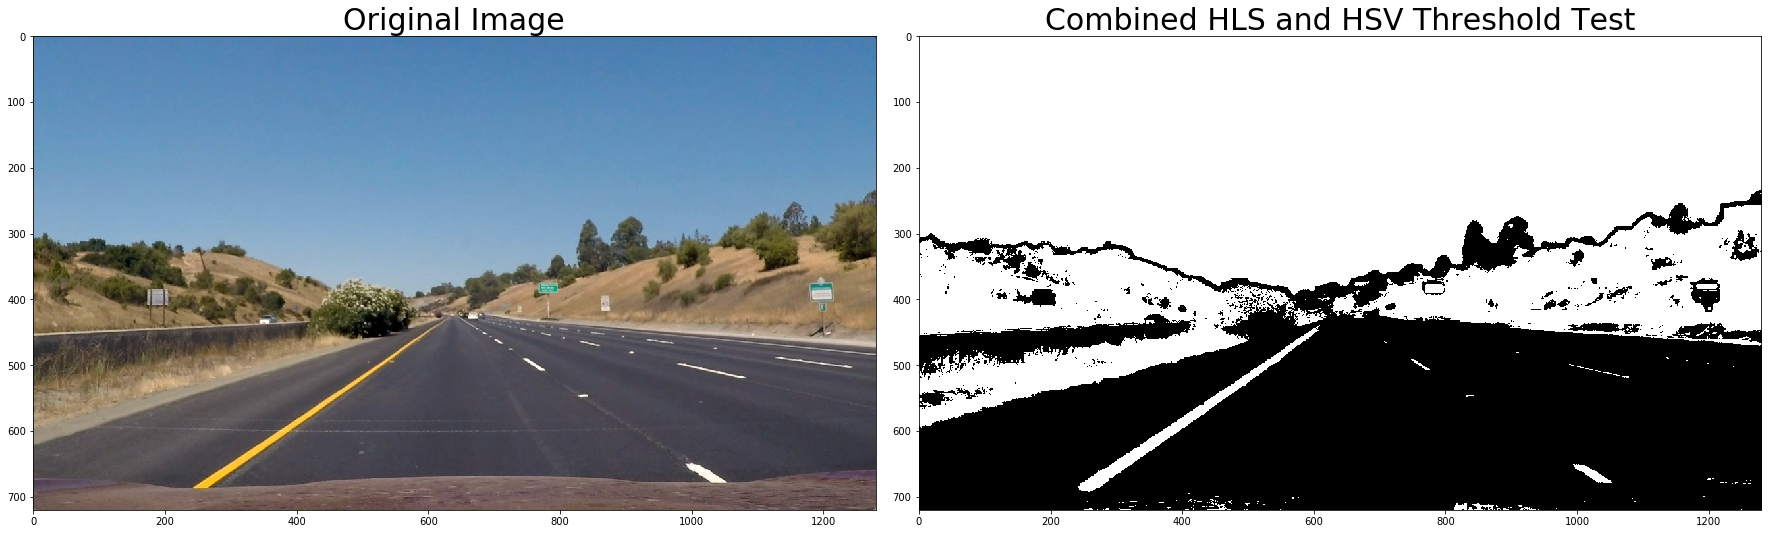

In [18]:
# Test the color_threshold function

# Read in a test image
#image_test = mpimg.imread('test_images/straight_lines1.jpg')

thresh_test = color_threshold(image_test, sthresh = (50,255), vthresh = (50,255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image_test)
ax1.set_title('Original Image', fontsize=30)

ax2.imshow(thresh_test, cmap='gray')
ax2.set_title('Combined HLS and HSV Threshold Test', fontsize=30)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('./output_images/' + 'color_thresh_test' + '.jpg')

### Binary Image for Pipeline Funciton
Define the final pipeline for producing the binary output image.

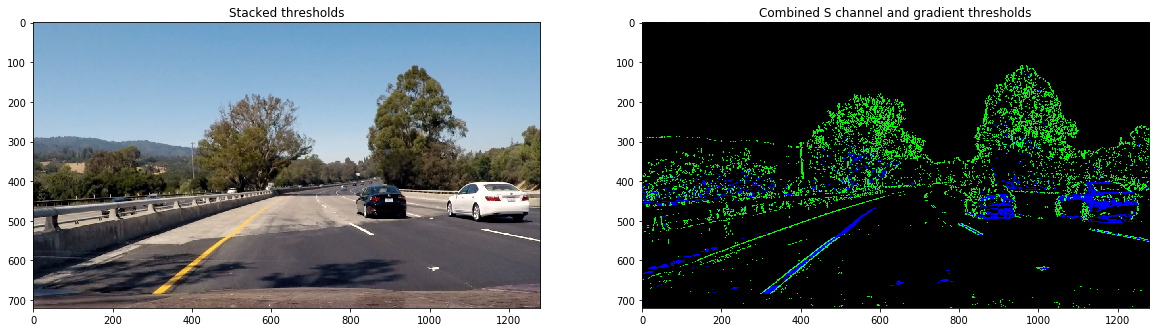

In [19]:
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100), sobel_kernel=9):
    
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # Take the derivative in x
    #sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel) # Take the derivative in x
    
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    #abs_sobely = np.absolute(sobely) # Absolute y derivative to accentuate lines away from horizontal
    
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary

img = mpimg.imread('test_images/test4.jpg')    
result = pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100), sobel_kernel = 3)


# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    
ax1.set_title('Stacked thresholds')
ax1.imshow(img)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(result, cmap='gray')

In [20]:
# Define undistortion function for input image using camera calibration

def pipeline_undistort(img, mtx, dist):
    
    return cv2.undistort(img, mtx, dist, None, mtx)

In [39]:
# Define top-down transformation for processing pipeline

def pipeline_topdown(image):

    img_size = (img.shape[1], img.shape[0])

    preprocessImage = np.zeros_like(img[:,:,0])

    bot_width = 0.75 # percent of bottom trapizoid height
    mid_width = 0.08 # percent of middle trapizoid height
    height_pct = 0.62 # percent for trapizoid width
    bottom_trim = 0.95 # percent from top to bottom to avoid car hood

    src = np.float32([[img.shape[1] * (0.5 - mid_width / 2), img.shape[0] * height_pct],
                      [img.shape[1] * (0.5 + mid_width / 2), img.shape[0] * height_pct],
                      [img.shape[1] * (0.5 + bot_width / 2), img.shape[0] * bottom_trim],
                      [img.shape[1] * (0.5 - bot_width / 2), img.shape[0] * bottom_trim]])

    offset = img_size[0] * 0.25

    dst = np.float32([[offset, 0], [img_size[0]-offset, 0], [img_size[0]-offset, img_size[1]], [offset, img_size[1]]])

    # Define topdown perspective transform

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective(image, M, img_size, flags = cv2.INTER_LINEAR)

    return warped, M

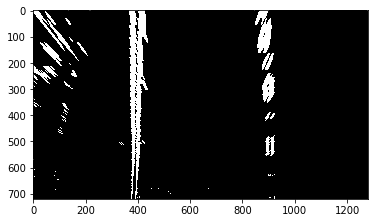

In [40]:
# Test the creation of binary_warped image including top-down transformation

grad_binary = abs_sobel_thresh(image_test, orient='x', thresh = (20, 250))
warped, M = pipeline_topdown(grad_binary)
plt.imshow(warped, cmap = 'gray')

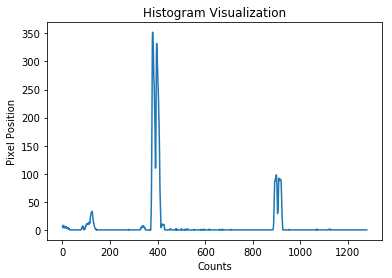

In [41]:
# Investigate the histogram of the binary_warped image

def histogram_vis(img):
    
    histogram = np.sum(img[int(img.shape[0]//2):,:], axis=0)
    
    plt.title('Histogram Visualization')
    plt.xlabel('Counts')
    plt.ylabel('Pixel Position')
    plt.plot(histogram)
    plt.savefig('./output_images/histogram_visualization.jpg')
    
    return

histogram_vis(warped)


### Define Lane Finding

In [24]:
# Read in a binary warped image example
#warped = mpimg.imread('./examples/warped_example.jpg')
binary_warped_example = mpimg.imread('./output_images/processed/3.jpg')

# window settings
window_width = 50
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

In [26]:
# Helps to draw boxes

def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0] - (level + 1) * height):int(img_ref.shape[0] - level * height), max(0, int(center - width/2)) : min(int(center + width/2), img_ref.shape[1])] = 1
    
    return output

In [48]:
def lane_line(binary_warped):
    
    # Input is binary_warped image,
    # highest proportaion of white vs black will be the lane lines
    # A histogram is produced for the bottom part of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    
    # Find peak historgram levels of the left and right sides of the histogram data
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Define the number of sliding windows to search with
    nwindows = 9
    
    # Define sliding window height
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices to the left and right lane lists
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each pixel set
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    #################################
    ### Visualization of lane finding
    #################################

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]

    # Generate colors for left and right lanes
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    ####################################################
    ### Derive radius of curvature from the polynomials
    ####################################################
    
    # Compute convsions between pixels and real-world dimensions
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty * ym_per_pix, left_fitx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty * ym_per_pix, right_fitx * xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad =  ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2 * right_fit_cr[0])
    
    # Compute car position
    m_car = binary_warped.shape[1] / 2
    m_lane = (left_fitx[0] + right_fitx[0]) / 2
    offset_right_from_center_m = (m_lane - m_car) * xm_per_pix
    
    # Compute radius of curvature in meters
    avg_radius_meters = np.mean([left_curverad, right_curverad])
    
    return out_img, avg_radius_meters, offset_right_from_center_m, left_fitx, right_fitx, ploty


In [ ]:
img_lines, r_meters, right_from_center_m, l_fit, r_fit, ploty = lane_line(warped)

In [27]:
# Find centroids from lanes

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center, r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0] / window_height)):
        
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids


In [31]:
window_centroids = find_window_centroids(binary_warped_example, window_width, window_height, margin)

In [30]:
# If we found any window centroids are found, draw point for building lane overlays

if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows
    for level in range(0, len(window_centroids)):
        
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width, window_height, warped, window_centroids[level][0], level)
        r_mask = window_mask(window_width, window_height, warped, window_centroids[level][1], level)

        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage= np.dstack((warped, warped, warped)) * 255 # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image

else:
    output = np.array(cv2.merge((warped, warped, warped)), np.uint8)

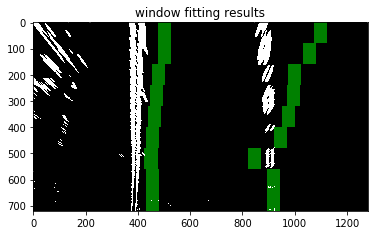

In [62]:
# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()

In [33]:
def  inv_transform(image, warped, Minv, left_fitx, right_fitx, ploty):
    
    # Create an image to draw the lines on
    color_warp = np.zeros_like(warped).astype(np.uint8)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))

    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    return result

Minv = np.linalg.inv(M)

final_output = inv_transform(img, img_lines, Minv, l_fit, r_fit, ploty)


In [34]:
# Define text to print out including lane features (radius of curvature) and vehicle position data

def lane_metrics():
    curve_fit_cr = np.polyfit(np.array(res_yvals, np.float32) * ym_per_pix, np.array(leftx, np.float32) * xm_per_pix, 2)
    curverad = ((1 + (2 * curve_fit_cr[0] * yvals[-1] * ym_per_pix + curve_fit_cr[1])**2)**1.5) / np.absolute(2*curve_fit_cr[0])
    camera_center = (left_fitx[-1] + right_fitx[-1]) / 2
    center_diff = (camera_center-img.shape[1]/2) * xm_per_pix
    side_pos = 'left'
    if center_diff <= 0:
        side_pos = 'right'
    cv2.putText(img, 'Radius of Curvature = ' + str(round(curverad, 3)) + 'm', (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, 
        (255,255,255), 2)
    cv2.putText(img, 'Vehicle is ' + str(abs(round(center_diff,3))) + 'm ' + side_pos + ' of center', (50,100), 
        cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)

In [35]:
# Define function to draw graphic overlays on the inverted image
# Image overlay shapes defined by inputs from found centroids

def image_overlays(img, centroids, warped):
    
    img = img.copy()
    leftx = [i[0] for i in centroids]
    rightx = [i[1] for i in centroids]
    
    yvals = range(img.shape[0])
    res_yvals = np.arange(img.shape[0]-(img.shape[0]/16), 0, -img.shape[0] / len(centroids) )
    
    # f(x) = Ax**2 + Bx + C
    left_fit = np.polyfit(res_yvals, leftx, 2)
    left_fitx = np.array(left_fit[0] * yvals * yvals +  left_fit[1] * yvals + left_fit[2], np.int32)

    right_fit = np.polyfit(res_yvals, rightx, 2)
    right_fitx = np.array(right_fit[0] * yvals * yvals +  right_fit[1] * yvals + right_fit[2], np.int32)
    
    textOverlay(img, res_yvals, yvals, leftx, left_fitx, right_fitx)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
   
    # Combine the result with the original image

    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

### Define video processing pipeline

In [36]:
# Implement functions in the processing pipeline for video processing
# Each video frame is processed and then a final output video is written

lane_images = [drawLane(i, c, t) for i, c, t in zip(undistort_images, detected_centroids, transformed_images)]


# Define lane lists to store outputs from centroid finding function

min_left_lane = []
max_left_lane = []
min_right_lane = []
max_right_lane = []

def process_img(img):
    
    # Undistort image
    img_undist = pipeline_undistort(img, mtx, dist)
    # returns: return cv2.undistort(img, mtx, dist, None, mtx)
        
    
    # Apply image color transformations
    #img_thresholded = thresholdImage(img_undist)
    img_thresholded = abs_sobel_thresh(img_undist, orient='x', thresh = (20, 250))
    
    # Apply perspective transformation
    img_top_down = pipeline_topdown(img_thresholded, src, dst)
    
    # Find centroids
    # define search window settings
    
    window_width = 50 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 100 # Set to serach left and right
    
    #centroids = findWindowCentroids(img_top_down, 50, 8)
    centriods = find_window_centroids(img_top_down, window_width, window_height, margin)
    
    # Append found features to centroid lists
    
    min_left_lane.append(centroids[:,0].min())
    max_left_lane.append(centroids[:,0].max())
    min_right_lane.append(centroids[:,1].min())
    max_right_lane.append(centroids[:,1].max())
    
    return drawLane(img_undistorted, centroids, img_transformed)

In [38]:
from moviepy.editor import VideoFileClip
from IPython.display import HTM

# Run the image processing function with the video script
    
input_video = 'project_video.mp4'
output_video = 'out_project_video.mp4'

clip = VideoFileClip(input_video)
video_clip = clip.fl_image(process_img)
video_clip.write_videofile(output_video, audio=False)


NameError: name 'src' is not defined